In [1]:
from configuration import config
config.pythonpath_fix()

## VQVAE Reconstructions

In [3]:
from ccbir.experiments import VQVAEExperiment
from ccbir.models.vqvae import VQVAE

exp = VQVAEExperiment(VQVAE.load_from_checkpoint(
    '/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_56/checkpoints/vqvae-morphomnist-epoch=480-val_loss=0.0163195.ckpt' 
))

Loading datamodule...
Loading test data...


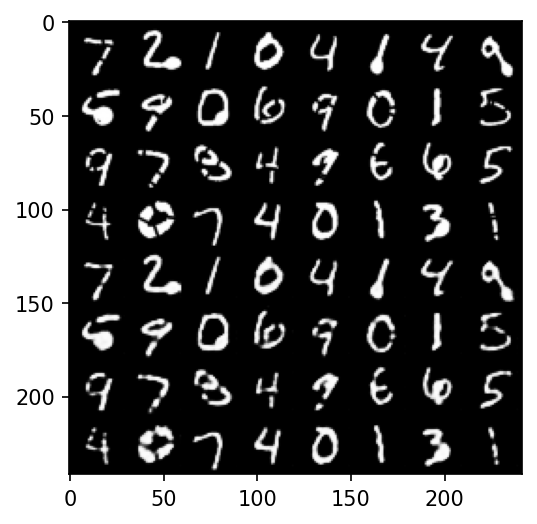

In [4]:
exp.show_vqvae_recons()

Loading datamodule...
Loading test data...
Computing TSNE...


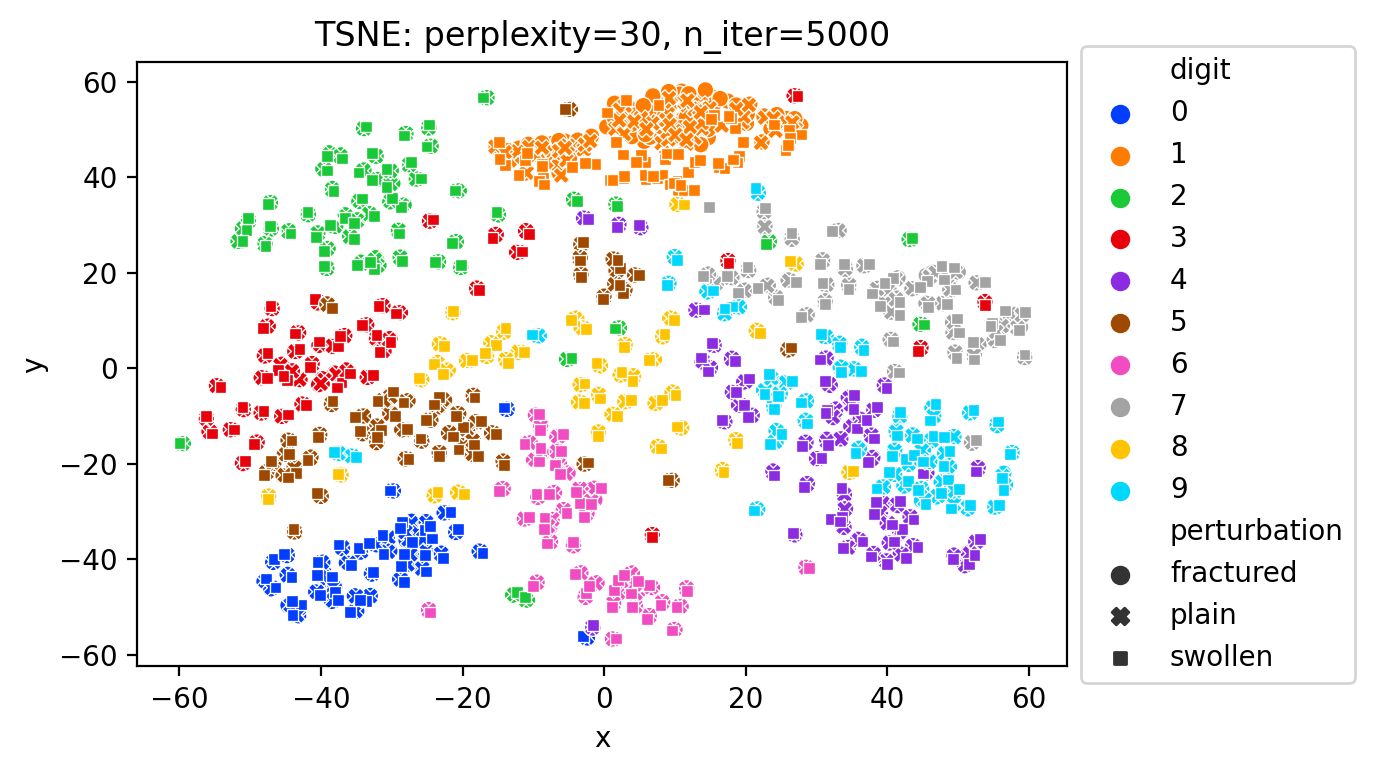

In [5]:
exp.plot_vqvae_tsne(perplexity=30, n_iter=5000)

## Example dataset item

test_data_plain[0]={'image': <PIL.Image.Image image mode=L size=28x28 at 0x7FF4B65A1DF0>, 'label': tensor(7, dtype=torch.uint8), 'metrics': {'area': tensor(69.5000), 'length': tensor(33.9277), 'thickness': tensor(2.1150), 'slant': tensor(0.0688), 'width': tensor(14.8377), 'height': tensor(19.6018)}}
{'image': <PIL.Image.Image image mode=L size=28x28 at 0x7FF4B5D57A30>, 'label': tensor(0, dtype=torch.uint8), 'metrics': {}, 'perturbations_args': {'thickness': 1.5, 'prune': 2.0, 'num_frac': 3.0}}


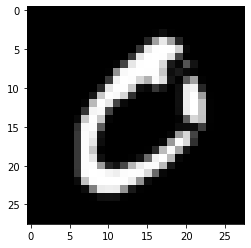

In [3]:
from ccbir.data.morphomnist.dataset import PerturbedMorphoMNIST, SwollenMorphoMNIST, FracturedMorphoMNIST, PlainMorphoMNIST
from ccbir.models.twin_network import PSFTwinNetDataset
from deepscm.datasets.morphomnist import MorphoMNISTLike

test_data = MorphoMNISTLike(str(config.original_mnist_data_path), train=False)
test_data_perturbed = FracturedMorphoMNIST(train=True)
test_data_plain = PlainMorphoMNIST(train=False)
psf_dataset = PSFTwinNetDataset(embed_image=lambda x: x, train=False)

#train_data_perturbed = PerturbedMorphoMNIST(Swelling, perturbation_sampler=SwellingSampler(), train=True)
print(f"{test_data_plain[0]=}")

print(test_data_perturbed[1])
plt.imshow(test_data_perturbed[1]['image'], cmap='gray')



In [7]:
x, y = psf_dataset[0]
x_shape = {k: v.shape for k, v in x.items()}
x_shape

NameError: name 'psf_dataset' is not defined

In [ ]:
from configuration import config
config.pythonpath_fix()
from ccbir.models.twin_network import SimpleDeepTwinNetComponent
from torchinfo import summary
import torch

model = SimpleDeepTwinNetComponent(2, 16, 32, torch.Size((16, 7, 7)))
print(f"{model.input_dim=}")
summary(model.network, (64, 2 + 16 + 32))

model.input_dim=50


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Linear: 1-1                            [64, 128]                 6,528
├─LeakyReLU: 1-2                         [64, 128]                 --
├─Unflatten: 1-3                         [64, 128, 1, 1]           --
├─ConvTranspose2d: 1-4                   [64, 64, 3, 3]            73,792
├─LeakyReLU: 1-5                         [64, 64, 3, 3]            --
├─ConvTranspose2d: 1-6                   [64, 32, 5, 5]            18,464
├─LeakyReLU: 1-7                         [64, 32, 5, 5]            --
├─ConvTranspose2d: 1-8                   [64, 16, 7, 7]            4,624
Total params: 103,408
Trainable params: 103,408
Non-trainable params: 0
Total mult-adds (M): 86.97
Input size (MB): 0.01
Forward/backward pass size (MB): 1.17
Params size (MB): 0.41
Estimated Total Size (MB): 1.60

In [ ]:
from ccbir.models.twin_network import SimpleDeepTwinNetComponent
from torchinfo import summary
import torch
from torch import nn

def Activation(): return nn.SiLU(inplace=True)

dim = 16 * 7 * 7
net = nn.Sequential(
    nn.LazyLinear(1024),
    Activation(),
    nn.LazyLinear(1024),
    Activation(),
    nn.LazyLinear(1024),
    Activation(),
    nn.LazyLinear(512),
    Activation(),
    nn.LazyLinear(196),
    nn.Unflatten(1, (4, 7, 7))
)
input_shape = (64, 2 + 16 + 32)
print(f"{input_shape=}")
summary(net, input_shape)

input_shape=(64, 50)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Linear: 1-1                            [64, 1024]                52,224
├─SiLU: 1-2                              [64, 1024]                --
├─Linear: 1-3                            [64, 1024]                1,049,600
├─SiLU: 1-4                              [64, 1024]                --
├─Linear: 1-5                            [64, 1024]                1,049,600
├─SiLU: 1-6                              [64, 1024]                --
├─Linear: 1-7                            [64, 512]                 524,800
├─SiLU: 1-8                              [64, 512]                 --
├─Linear: 1-9                            [64, 196]                 100,548
├─Unflatten: 1-10                        [64, 4, 7, 7]             --
Total params: 2,776,772
Trainable params: 2,776,772
Non-trainable params: 0
Total mult-adds (M): 177.71
Input size (MB): 0.01
F

In [5]:
from ccbir.experiments import PSFTwinNetExperiment
from ccbir.models.vqvae import VQVAE
from ccbir.models.twin_network import PSFTwinNet
from ccbir.models.model import load_best_model

exp = PSFTwinNetExperiment(
    vqvae=load_best_model(VQVAE),
    twinnet=PSFTwinNet.load_from_checkpoint(
        '/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_59/checkpoints/twinnet-epoch=804-val_loss=0.2381465.ckpt'
    )
)

/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs


/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


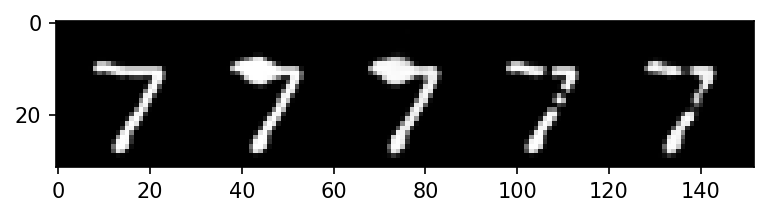

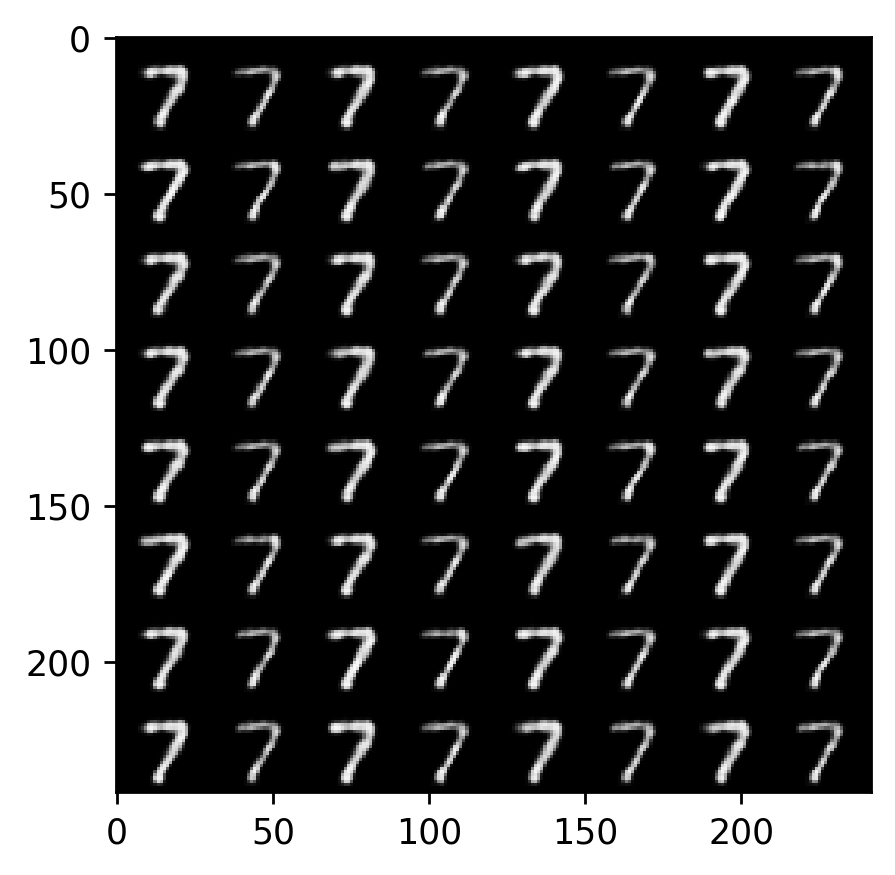

In [6]:
exp.show_twinnet_samples(0)

original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs


/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


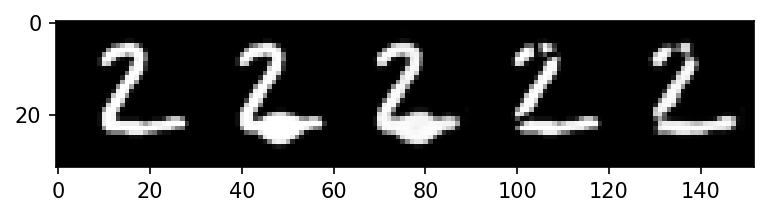

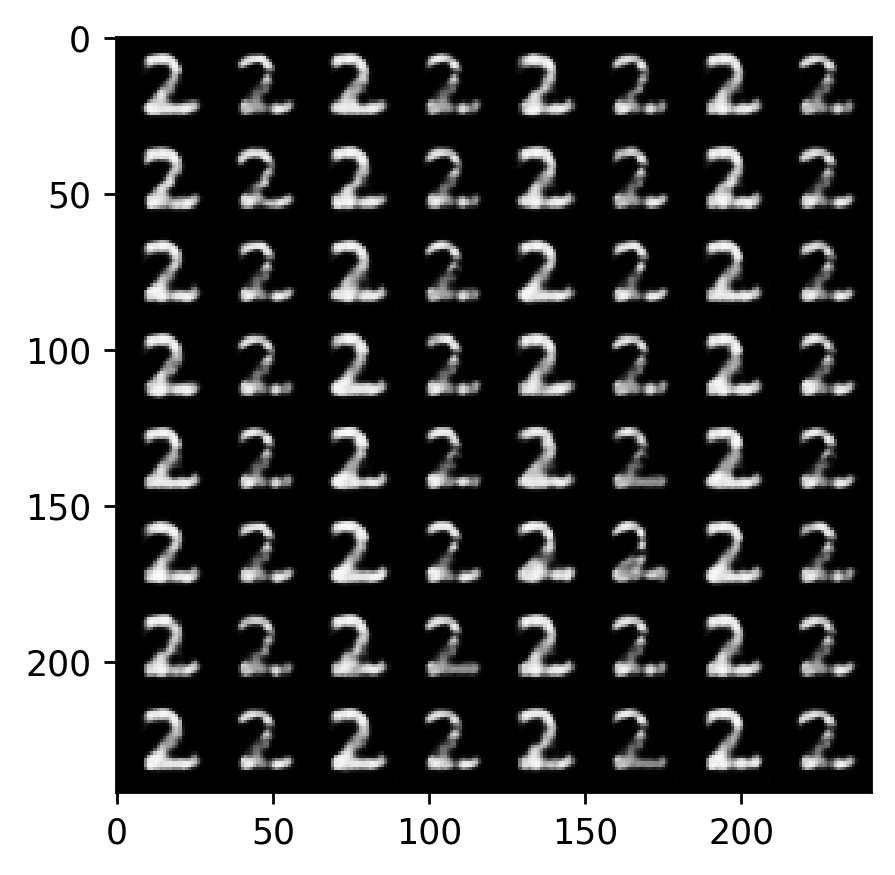

In [8]:
exp.show_twinnet_samples(1)

original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs


/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


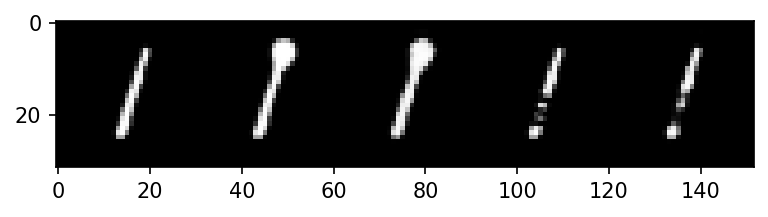

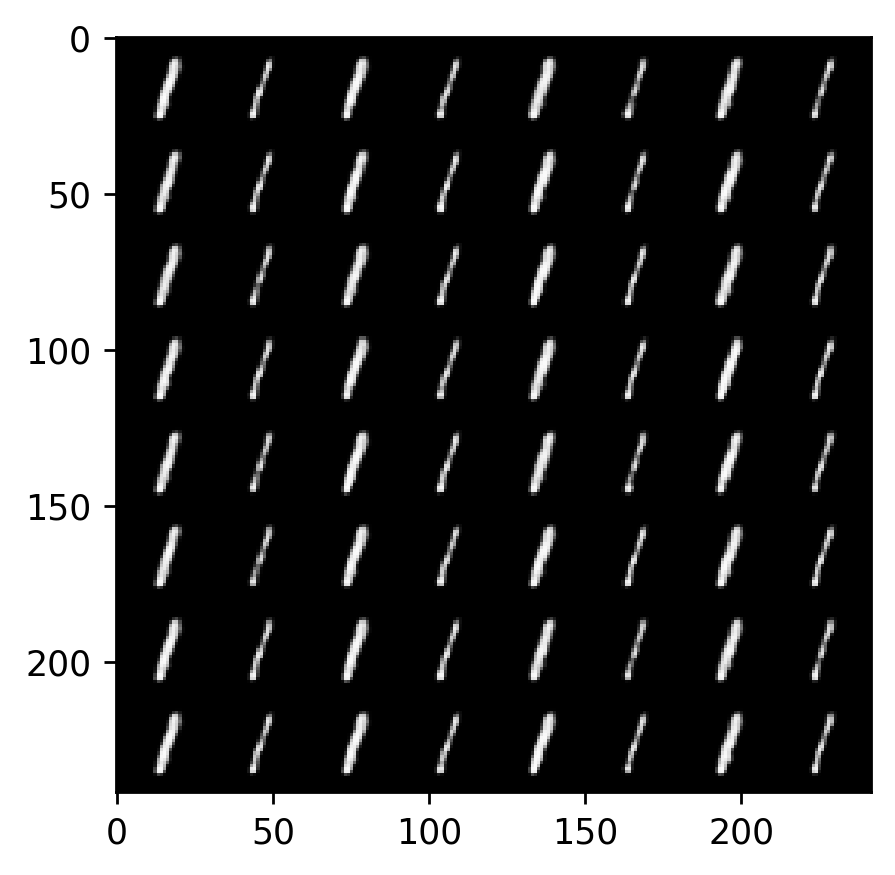

In [9]:
exp.show_twinnet_samples(2)

original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs


/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


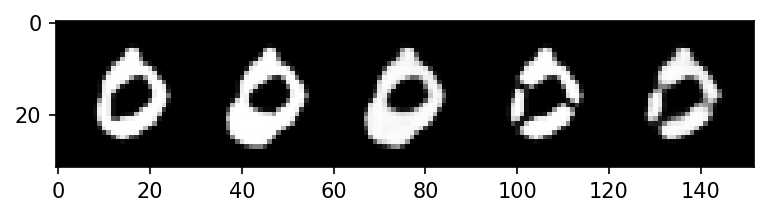

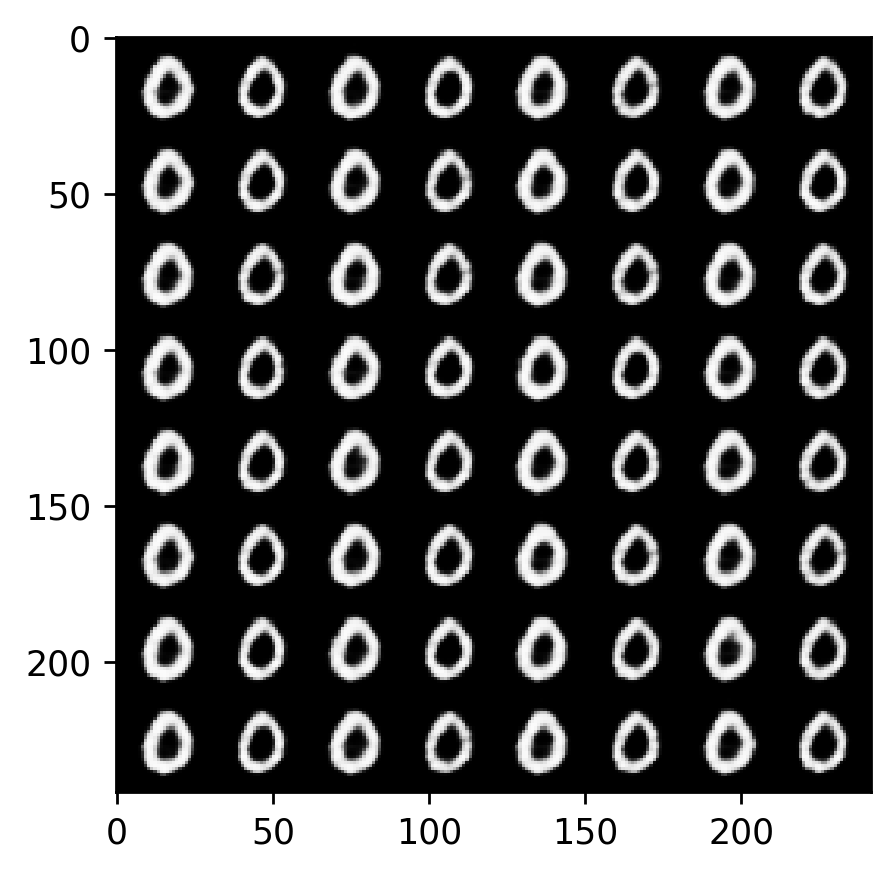

In [10]:
exp.show_twinnet_samples(3)